<a href="https://colab.research.google.com/github/2256haradityam/Projects/blob/main/CARPRICEPREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv('https://github.com/2256haradityam/dataset/raw/refs/heads/main/bcn.csv')

In [11]:
df.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,39,1,34,2,0,3,1,1,0
1,0,49,1,24,2,0,2,2,3,0
2,0,49,1,24,2,0,2,1,1,0
3,0,69,2,19,2,0,2,2,2,0
4,0,49,1,4,2,0,2,2,4,0


In [12]:
dfn = df.copy()

In [13]:
dfn['breast'].value_counts()

,count
breast,
1,151
2,134


In [14]:
dfn['breast'] = dfn['breast'].map({1: 0, 2: 1})

In [15]:
columns_to_encode = ['age', 'inv-nodes', 'deg-malig', 'tumor-size', 'irradiat',  'breast-quad', 'menopause']

# Perform One-Hot Encoding on selected columns
df_encoded = pd.get_dummies(dfn, columns=columns_to_encode)

# Convert only the columns created from `columns_to_encode` to int
encoded_columns = df_encoded.columns[df_encoded.columns.str.contains('_'.join(columns_to_encode))]
df_encoded[encoded_columns] = df_encoded[encoded_columns].astype(int)


In [16]:
import pandas as pd
from scipy.stats import pearsonr

# Define ranges for numerator and denominator power ratios
numerator_powers = range(1, 20)
denominator_powers = range(1, 20)

# Initialize variables to store the best power ratios and correlation
best_numerator_power = 0
best_denominator_power = 0
best_correlation = -1

# Iterate through different power ratios
for numerator_power in numerator_powers:
    for denominator_power in denominator_powers:
        dfn['new_column'] = ((dfn['tumor-size'] * dfn['inv-nodes'] * dfn['deg-malig'])**numerator_power)/((dfn['age']*dfn['menopause'])**denominator_power)
        correlation = pearsonr(dfn['new_column'], dfn['class'])[0]
        if correlation > best_correlation:
            best_numerator_power = numerator_power
            best_denominator_power = denominator_power
            best_correlation = correlation

# Apply the best power ratios to calculate the final 'new_column'
dfn['new_column'] = ((dfn['tumor-size'] * dfn['inv-nodes'] * dfn['deg-malig'])**best_numerator_power)/((dfn['age']*dfn['menopause'])**best_denominator_power)

print("Best numerator power:", best_numerator_power)
print("Best denominator power:", best_denominator_power)
print("Best correlation:", best_correlation)

Best numerator power: 1
Best denominator power: 1
Best correlation: 0.313585457213801


In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_encoded['new_column'] = scaler.fit_transform(dfn[['new_column']])

<Axes: >

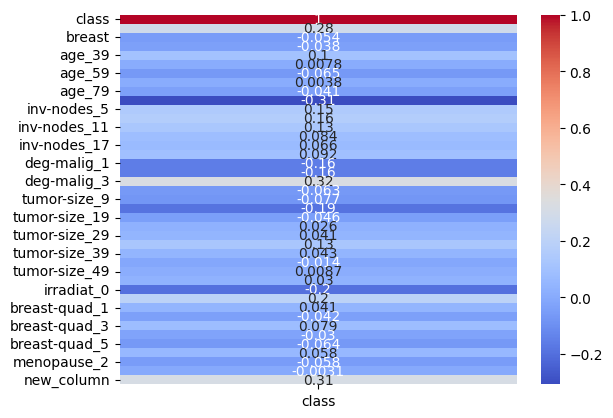

In [18]:
sns.heatmap(df_encoded.corr()[['class']], annot=True, cmap='coolwarm')

In [19]:
print(dfn[(dfn['class'] == 0)].groupby('class').mean().to_string())

             age  menopause  tumor-size  inv-nodes  node-caps  deg-malig    breast  breast-quad  irradiat  new_column
class                                                                                                                
0      56.114428   1.517413   27.208955   2.955224   0.124378   1.905473  0.487562     2.159204   0.18408    2.556824


class

0      56.114428   1.517413   27.208955   2.955224   0.124378   1.905473  1.487562     2.159204   0.18408

1      54.47619   1.452381   31.202381   5.071429   0.369048   2.380952  1.428571      2.02381    0.369048

In [20]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   class          285 non-null    int64  
 1   node-caps      285 non-null    int64  
 2   breast         285 non-null    int64  
 3   age_29         285 non-null    bool   
 4   age_39         285 non-null    bool   
 5   age_49         285 non-null    bool   
 6   age_59         285 non-null    bool   
 7   age_69         285 non-null    bool   
 8   age_79         285 non-null    bool   
 9   inv-nodes_2    285 non-null    bool   
 10  inv-nodes_5    285 non-null    bool   
 11  inv-nodes_8    285 non-null    bool   
 12  inv-nodes_11   285 non-null    bool   
 13  inv-nodes_14   285 non-null    bool   
 14  inv-nodes_17   285 non-null    bool   
 15  inv-nodes_26   285 non-null    bool   
 16  deg-malig_1    285 non-null    bool   
 17  deg-malig_2    285 non-null    bool   
 18  deg-malig_

In [21]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming 'df_encoded' is your encoded DataFrame with the target column 'class'
target_column = 'class'

# Split into features and target
X = df_encoded.drop(target_column, axis=1)
y = df_encoded[target_column]

# Apply PCA for dimensionality reduction and GINI for feature selection
# Standard scaling before PCA is essential
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA (reduce to 95% variance retained)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Duplicate the data 10 times
X_duplicated = pd.concat([pd.DataFrame(X_pca)] * 10, ignore_index=True)
y_duplicated = pd.concat([y] * 10, ignore_index=True)

# Combine features and target for easier manipulation
df_duplicated = pd.concat([X_duplicated, y_duplicated], axis=1)

# Insert rows ensuring a minimum gap of 3 between duplicates
final_data = []
for i in range(10):  # Loop over the 10 copies
    gap_start = i * 3
    final_data[gap_start:gap_start] = df_duplicated.iloc[i * len(df_encoded):(i + 1) * len(df_encoded)].values.tolist()

# Convert back to DataFrame after interspersing duplicates
df_interspersed = pd.DataFrame(final_data, columns=list(df_duplicated.columns) )

# Shuffle the final DataFrame in a highly random order
df_shuffled = df_interspersed.sample(frac=1, random_state=42).reset_index(drop=True)

# Split shuffled data back into features and target
X_shuffled = df_shuffled.drop(target_column, axis=1)
y_shuffled = df_shuffled[target_column]

# Define classifiers and parameter grids
classifiers = {
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': GaussianNB(),
    'SVM': SVC(),
    'ZeroR': DummyClassifier(strategy='most_frequent')
}

param_grids = {
    'DecisionTree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'NaiveBayes': {},  # No hyperparameters to tune for GaussianNB
    'ZeroR': {}  # No hyperparameters for DummyClassifier (ZeroR)
}

# Different train-test split ratios
train_test_splits = [
    0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14,
    0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24,
    0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34,
    0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44,
    0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54,
    0.55, 0.56, 0.57, 0.58, 0.59, 0.6
]

best_models = {}
for split_ratio in train_test_splits:
    print(f"\nEvaluating with train_test_split ratio: {1 - split_ratio} train, {split_ratio} test\n")

    # Split the shuffled data
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=split_ratio, random_state=42)

    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name} with split {split_ratio}...")

        if clf_name in param_grids and param_grids[clf_name]:
            # Brute force with GridSearchCV for classifiers with hyperparameters
            grid_search = GridSearchCV(clf, param_grids[clf_name], n_jobs=-1, verbose=1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            # For classifiers without hyperparameters to tune (like NaiveBayes, ZeroR)
            clf.fit(X_train, y_train)
            best_model = clf

        # Evaluate the best model on the test data
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{clf_name} Accuracy with split {split_ratio}: {accuracy}")
        print(f"{clf_name} Classification Report with split {split_ratio}:\n")
        print(classification_report(y_test, y_pred))

        # Store the best model for each classifier and split
        best_models[(clf_name, split_ratio)] = best_model

# After completing all splits, the best models for each classifier and split will be stored in `best_models`



Evaluating with train_test_split ratio: 0.95 train, 0.05 test


Training DecisionTree with split 0.05...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
DecisionTree Accuracy with split 0.05: 0.958041958041958
DecisionTree Classification Report with split 0.05:

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       107
         1.0       0.89      0.94      0.92        36

    accuracy                           0.96       143
   macro avg       0.94      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143


Training NaiveBayes with split 0.05...
NaiveBayes Accuracy with split 0.05: 0.7832167832167832
NaiveBayes Classification Report with split 0.05:

              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       107
         1.0       0.56      0.61      0.59        36

    accuracy                           0.78       143
   macro avg       0.71      0

In [23]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming 'df_encoded' is your encoded DataFrame with the target column 'class'
target_column = 'class'

# Split into features and target
X = df_encoded.drop(target_column, axis=1)
y = df_encoded[target_column]

# Apply PCA for dimensionality reduction and GINI for feature selection
# Standard scaling before PCA is essential
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Applying PCA (reduce to 95% variance retained)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

# Duplicate the data 10 times
X_duplicated = pd.concat([pd.DataFrame(X_pca)] * 10, ignore_index=True)
y_duplicated = pd.concat([y] * 10, ignore_index=True)

# Combine features and target for easier manipulation
df_duplicated = pd.concat([X_duplicated, y_duplicated], axis=1)

# Insert rows ensuring a minimum gap of 3 between duplicates
final_data = []
for i in range(10):  # Loop over the 10 copies
    gap_start = i * 3
    final_data[gap_start:gap_start] = df_duplicated.iloc[i * len(df_encoded):(i + 1) * len(df_encoded)].values.tolist()

# Convert back to DataFrame after interspersing duplicates
df_interspersed = pd.DataFrame(final_data, columns=list(df_duplicated.columns) )

# Shuffle the final DataFrame in a highly random order
df_shuffled = df_interspersed.sample(frac=1, random_state=42).reset_index(drop=True)

# Split shuffled data back into features and target
X_shuffled = df_shuffled.drop(target_column, axis=1)
y_shuffled = df_shuffled[target_column]

# Define classifiers and parameter grids
classifiers = {
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': GaussianNB(),
    'SVM': SVC(),
    'ZeroR': DummyClassifier(strategy='most_frequent')
}

param_grids = {
    'DecisionTree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'NaiveBayes': {},  # No hyperparameters to tune for GaussianNB
    'ZeroR': {}  # No hyperparameters for DummyClassifier (ZeroR)
}

# Different train-test split ratios
train_test_splits = [
    0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14,
    0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24,
    0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34,
    0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44,
    0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54,
    0.55, 0.56, 0.57, 0.58, 0.59, 0.6
]

best_models = {}
for split_ratio in train_test_splits:
    print(f"\nEvaluating with train_test_split ratio: {1 - split_ratio} train, {split_ratio} test\n")

    # Split the shuffled data
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=split_ratio, random_state=42)

    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name} with split {split_ratio}...")

        if clf_name in param_grids and param_grids[clf_name]:
            # Brute force with GridSearchCV for classifiers with hyperparameters
            grid_search = GridSearchCV(clf, param_grids[clf_name], n_jobs=-1, verbose=1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            # For classifiers without hyperparameters to tune (like NaiveBayes, ZeroR)
            clf.fit(X_train, y_train)
            best_model = clf

        # Evaluate the best model on the test data
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{clf_name} Accuracy with split {split_ratio}: {accuracy}")
        print(f"{clf_name} Classification Report with split {split_ratio}:\n")
        print(classification_report(y_test, y_pred))

        # Store the best model for each classifier and split
        best_models[(clf_name, split_ratio)] = best_model

# After completing all splits, the best models for each classifier and split will be stored in `best_models`



Evaluating with train_test_split ratio: 0.95 train, 0.05 test


Training DecisionTree with split 0.05...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
DecisionTree Accuracy with split 0.05: 0.958041958041958
DecisionTree Classification Report with split 0.05:

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       107
         1.0       0.89      0.94      0.92        36

    accuracy                           0.96       143
   macro avg       0.94      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143


Training NaiveBayes with split 0.05...
NaiveBayes Accuracy with split 0.05: 0.7832167832167832
NaiveBayes Classification Report with split 0.05:

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86       107
         1.0       0.57      0.56      0.56        36

    accuracy                           0.78       143
   macro avg       0.71      0